In [383]:
import os
import matplotlib.pyplot as plt
import cvxportfolio as cvx
import yfinance as yf
import pandas as pd
import numpy as np
import datetime

In [384]:
cvx.forecast.HistoricalFactorizedCovariance()

HistoricalFactorizedCovariance(half_life=inf, rolling=inf, kelly=True)

In [385]:
stocksdf = pd.read_csv("sp500_stocks.csv")
stock_names = sorted(['AON', 'BX', 'MCD', 'T', 'MDLZ', 'JNJ', 'IBM', 'CBOE'])
#    ['AMZN', 'BX', 'CTAS', 'CVX', 'GM', 'GOOG', 'NVDA']
volstock_idx = stock_names.index('BX')
prices = stocksdf[['Date', 'Symbol', 'Adj Close']]
prices = prices[prices['Symbol'].isin(stock_names)]
prices.loc[:, 'Date'] = pd.to_datetime(prices['Date'])
prices = prices.pivot(index='Date', columns='Symbol', values='Adj Close')

stocksdf['Volumes'] = stocksdf['Volume'] * stocksdf['Adj Close']
volumes = stocksdf[['Date', 'Symbol', 'Volumes']]
volumes = volumes[volumes['Symbol'].isin(stock_names)]
volumes.loc[:, 'Date'] = pd.to_datetime(volumes['Date'])
volumes = volumes.pivot(index='Date', columns='Symbol', values='Volumes')

returns = prices.pct_change()

usd = pd.read_csv('FEDFUNDS.csv')
usd['DATE'] = pd.to_datetime(usd['DATE'])
usd = usd[usd['DATE'] >= pd.Timestamp('2010-01-01')]
usd = usd.set_index('DATE')

def get_fedfunds_rate(date, usd_df):
    first_day_of_month = pd.Timestamp(year=date.year, month=date.month, day=1)
    return usd_df.loc[first_day_of_month, 'FEDFUNDS']

returns['FEDFUNDS'] = returns.index.map(lambda date: get_fedfunds_rate(date, usd))
returns['FEDFUNDS'] = returns['FEDFUNDS'] / 100
returns['FEDFUNDS'] = (1 + returns['FEDFUNDS'])**(1/252) - 1 

In [386]:
prices_real = prices
returns_real = returns
volumes_real = volumes

returns_real = returns_real.rename(columns={'FEDFUNDS': 'USDOLLAR'})
returns_real = returns_real.dropna()
prices_real = prices_real.dropna()
volumes_real = volumes_real.dropna()

In [389]:
# Historical Data

# Initialize stock market simulator
simulator = cvx.MarketSimulator(returns = returns_real, volumes = volumes_real, prices = prices_real)

# Create objective function and constraints to the optimization problem

constraints = [cvx.LongCash()]
gamma_trade = 2.5
gamma_hold = 2.5

def make_policy(gamma_trade, gamma_risk, constraints):
    return cvx.MultiPeriodOptimization(cvx.ReturnsForecast()
                                       - gamma_trade * cvx.StocksTransactionCost()
                                       - gamma_hold * cvx.StocksHoldingCost() - cvx.FullCovariance(),
                                          constraints, planning_horizon=12)

policy = make_policy(1, 1, constraints)

# objective = cvx.ReturnsForecast()
#             - gamma_trade * cvx.StocksTransactionCost() - gamma_hold * cvx.StocksHoldingCost()
#             - cvx.FullCovariance()

# Initialize policy
# policy = cvx.MultiPeriodOptimization(objective, constraints, planning_horizon=12)

# backtest
results = simulator.backtest_many([policy, cvx.Uniform()], start_time='2022-01-01', end_time='2023-01-01')


# MULTI-PERIOD OPTIMIZATION


###########################################################
Universe size                                             9
Initial timestamp                       2022-01-03 00:00:00
Final timestamp                         2022-12-30 00:00:00
Number of periods                                       251
Initial value (USDOLLAR)                          1.000e+06
Final value (USDOLLAR)                            7.130e+05
Profit (USDOLLAR)                                -2.870e+05
                                                           
Avg. return (annualized)                             -25.3%
Volatility (annualized)                               42.6%
Avg. excess return (annualized)                      -27.0%
Avg. active return (annualized)                      -27.0%
Excess volatility (annualized)                        42.6%
Active volatility (annualized)                        42.6%
                                                           
Avg. grow

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/cvxportfolio/result.py:987: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show() # pragma: no cover


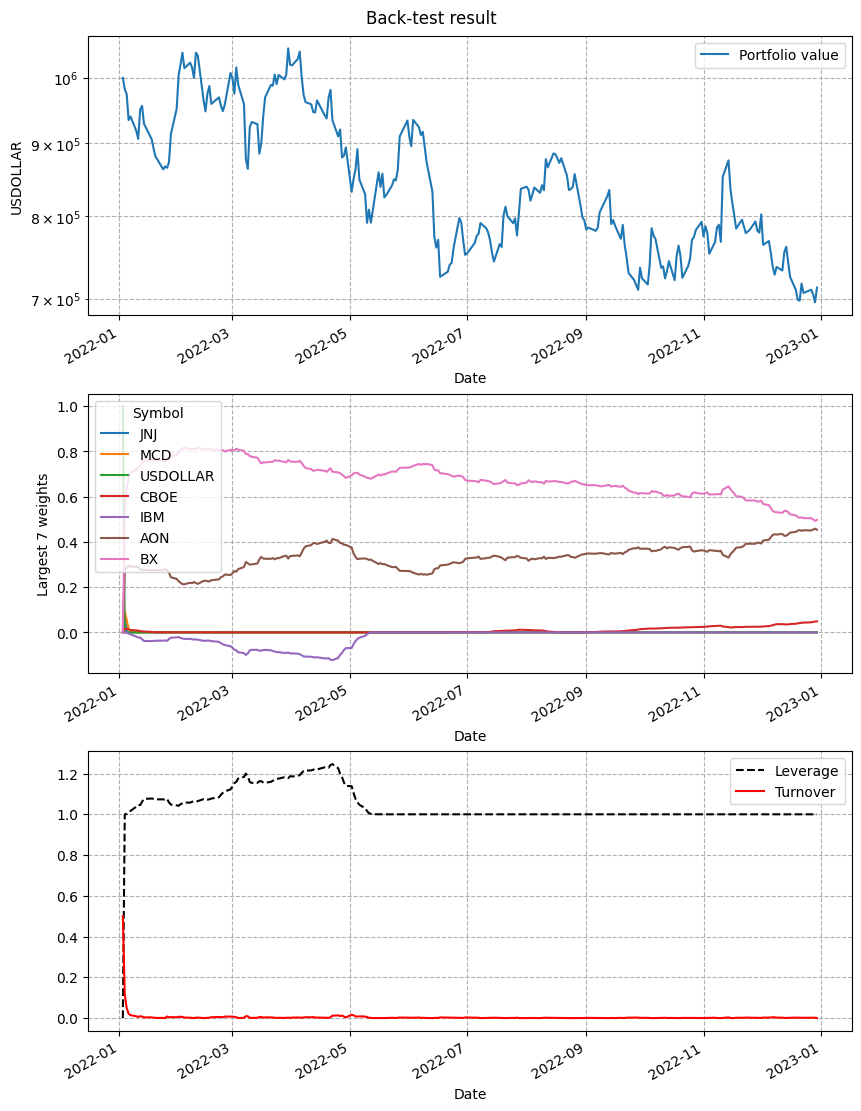

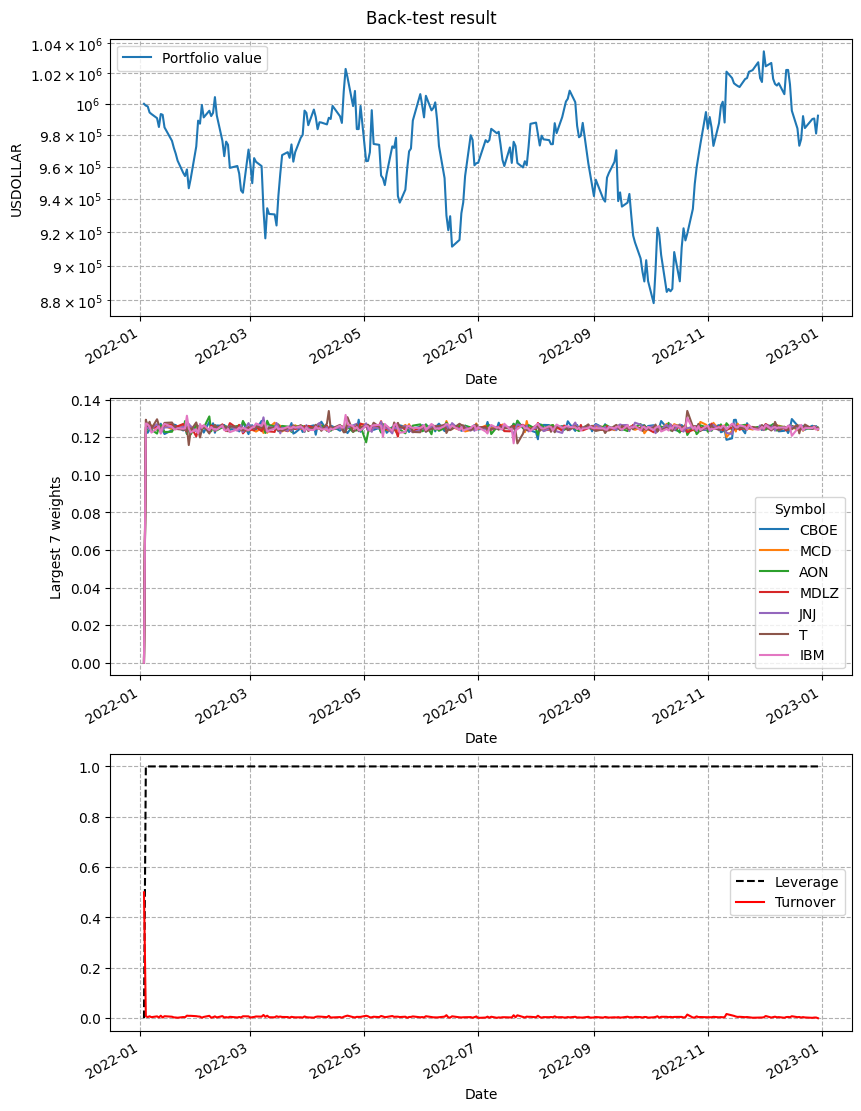

In [390]:
# print multi-period result
print("\n# MULTI-PERIOD OPTIMIZATION\n")
print(results[0])

# print uniform allocation result
print("\n# UNIFORM ALLOCATION:\n")
print(results[1])

# plot value and weights of the portfolio in time for MPO
mpo_figure = results[0].plot()

# plot value and weights of the portfolio in time for uniform
uniform_figure = results[1].plot()

In [393]:
stocks = returns_real.columns

In [394]:
returns_prev = returns_real[returns_real.index < pd.Timestamp('2022-01-01')]
stocks_only = returns_prev[stock_names]
stockmat = stocks_only.to_numpy()
stockmat = stockmat.T
x = np.mean(stockmat, axis=1)
cor = np.corrcoef(stockmat)
bx = stockmat[volstock_idx]
var_bx = np.var(stockmat[volstock_idx])

In [395]:
returns_2 = returns_real[returns_real.index >= pd.Timestamp('2022-01-01')]
returns_2 = returns_2[returns_2.index <= pd.Timestamp('2023-01-01')]
stocks_2 = returns_2[stock_names]
stockmat2 = stocks_2.to_numpy()
stockmat2 = stockmat2.T
bx2 = stockmat2[volstock_idx]
var_bx2 = np.var(bx2)
m = var_bx2 / var_bx
m = m ** 0.5

In [396]:
idx1 = len(returns_prev)

In [397]:
idx2 = len(returns_real)

In [398]:
demeaned = bx - np.mean(bx)
scaled = demeaned * m
newbx = scaled + np.mean(bx)
newbx = newbx.T
newbx.shape
returns_new = returns_real.copy()
returns_new.iloc[:idx1, volstock_idx] = newbx
init = prices_real.iloc[0, :].to_numpy()
rets = returns_new[stock_names]
ret = rets.to_numpy()
prices_new = prices_real.copy()
curr_price =  prices_real.iloc[idx2, :].to_numpy()
curr_price = curr_price[volstock_idx]
for i in range(len(ret) - 1, -1, -1):
    curr_ret = ret[i][volstock_idx] + 1
    curr_price = curr_price / curr_ret
    prices_new.iloc[i, volstock_idx] = curr_price
    
    

In [401]:
# Historical Data

# Initialize stock market simulator
simulator = cvx.MarketSimulator(returns = returns_new, volumes = volumes_real, prices = prices_new)

# Create objective function and constraints to the optimization problem

constraints = [cvx.LongCash()]
gamma_trade = 2.5
gamma_hold = 2.5

def make_policy(gamma_trade, gamma_risk, constraints):
    return cvx.MultiPeriodOptimization(cvx.ReturnsForecast()
                                       - gamma_trade * cvx.StocksTransactionCost()
                                       - gamma_hold * cvx.StocksHoldingCost() - cvx.FullCovariance(),
                                          constraints, planning_horizon=12)

policy = make_policy(1, 1, constraints)

# objective = cvx.ReturnsForecast()
#             - gamma_trade * cvx.StocksTransactionCost() - gamma_hold * cvx.StocksHoldingCost()
#             - cvx.FullCovariance()

# Initialize policy
# policy = cvx.MultiPeriodOptimization(objective, constraints, planning_horizon=12)

# backtest
results = simulator.backtest_many([policy, cvx.Uniform()], start_time='2022-01-01', end_time='2023-01-01')


# MULTI-PERIOD OPTIMIZATION


###########################################################
Universe size                                             9
Initial timestamp                       2022-01-03 00:00:00
Final timestamp                         2022-12-30 00:00:00
Number of periods                                       251
Initial value (USDOLLAR)                          1.000e+06
Final value (USDOLLAR)                            9.168e+05
Profit (USDOLLAR)                                -8.319e+04
                                                           
Avg. return (annualized)                              -5.0%
Volatility (annualized)                               27.6%
Avg. excess return (annualized)                       -6.7%
Avg. active return (annualized)                       -6.7%
Excess volatility (annualized)                        27.6%
Active volatility (annualized)                        27.6%
                                                           
Avg. grow

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/cvxportfolio/result.py:987: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show() # pragma: no cover


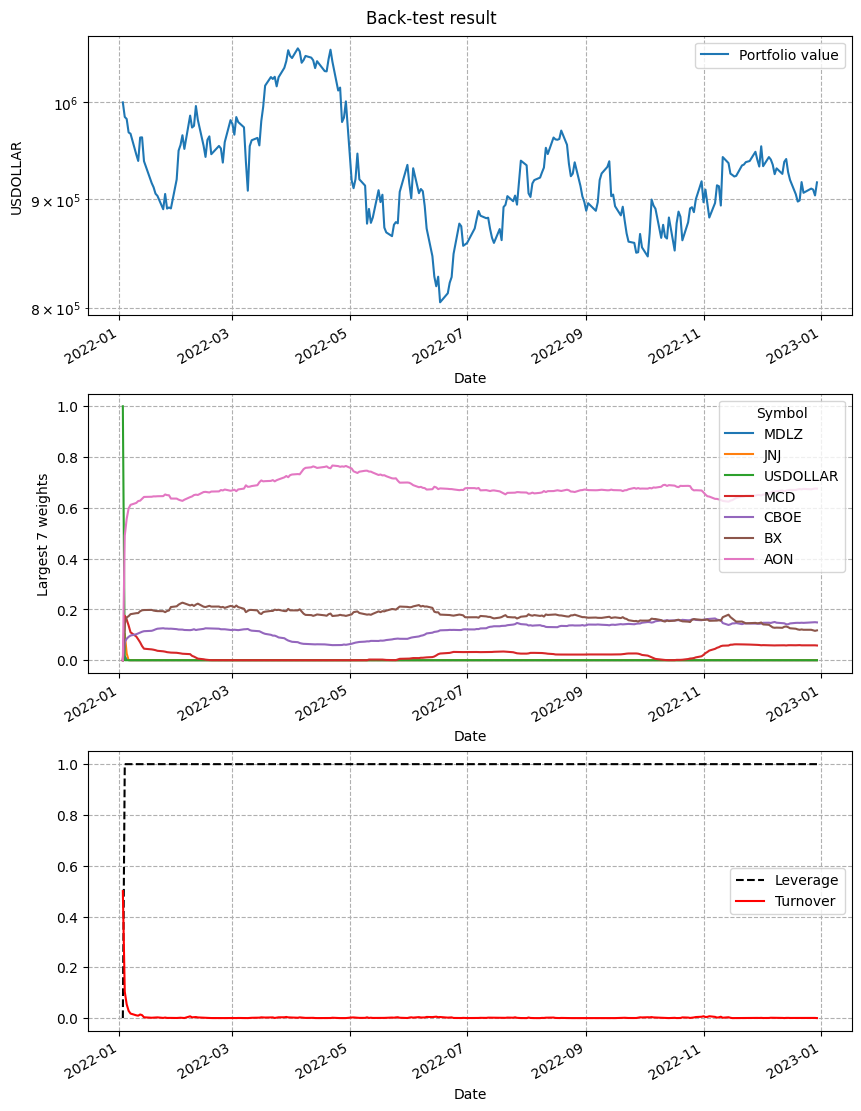

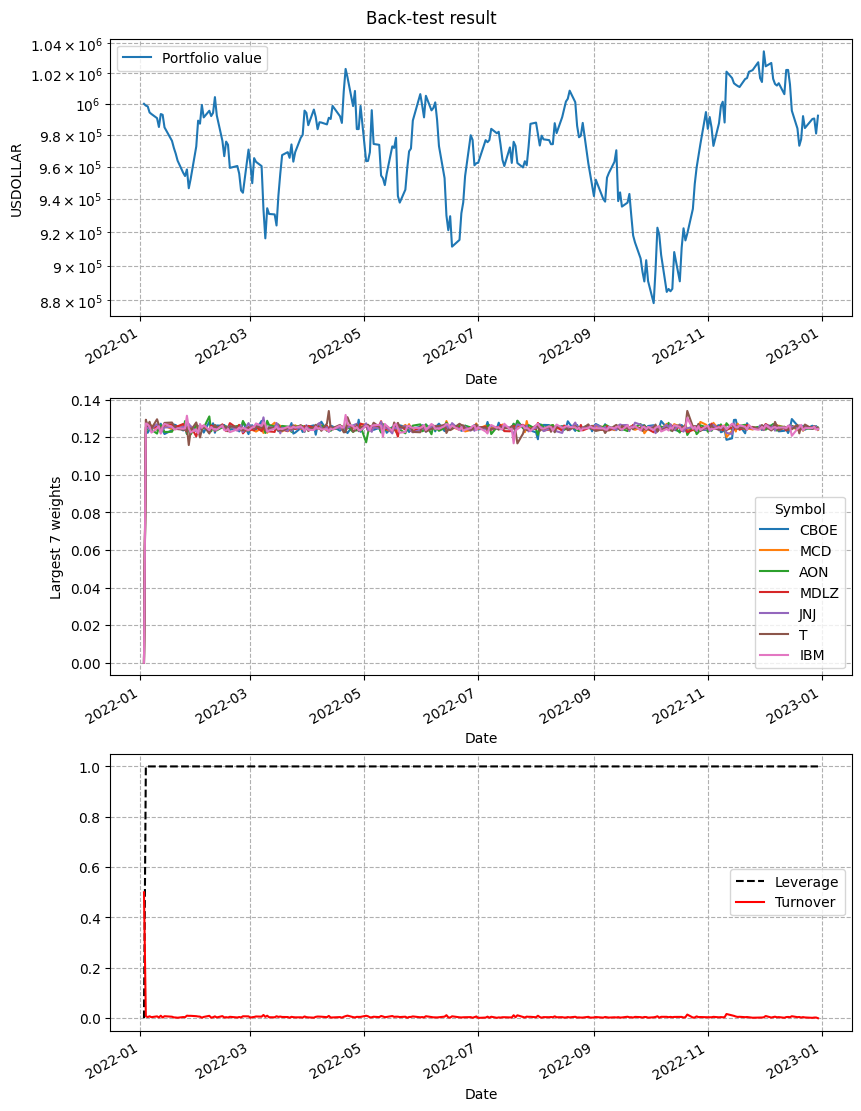

In [402]:
# print multi-period result
print("\n# MULTI-PERIOD OPTIMIZATION\n")
print(results[0])

# print uniform allocation result
print("\n# UNIFORM ALLOCATION:\n")
print(results[1])

# plot value and weights of the portfolio in time for MPO
mpo_figure = results[0].plot()

# plot value and weights of the portfolio in time for uniform
uniform_figure = results[1].plot()

In [403]:
bx_og = prices_real['BX']

In [404]:
bx_edit = prices_new['BX']

<function matplotlib.pyplot.show(close=None, block=None)>

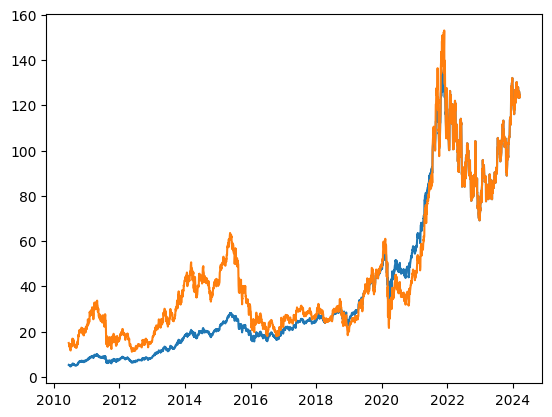

In [405]:
plt.plot(bx_og)
plt.plot(bx_edit)
plt.show

In [408]:
(((3895 - 4677) / 4677)+1)*1000000

832798.8026512722